# The Perceptron
Let us implement a perceptron.
As a reminder, our perceptron takes multiple inputs, weights each of them with a certain factor and checks if the sum is bigger than a threshold.
![Perceptron](./images/perceptron.png)
First we are going to collect the data to run this example:

In [1]:
! mkdir -p ~/data/workshop_data
! wget -c --retry-connrefused --tries=0 https://archive.ics.uci.edu/ml/machine-learning-databases/00357/occupancy_data.zip -O ~/data/workshop_data/occupancy_data.zip
! unzip ~/data/workshop_data/occupancy_data.zip -d ~/data/workshop_data/occupancy_data

--2019-04-15 16:27:21--  https://archive.ics.uci.edu/ml/machine-learning-databases/00357/occupancy_data.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 335713 (328K) [application/x-httpd-php]
Saving to: ‘/home/ec2-user/data/workshop_data/occupancy_data.zip’

/home/ec2-user/data 100%[===================>] 327.84K  --.-KB/s    in 0.1s    

2019-04-15 16:27:22 (2.32 MB/s) - ‘/home/ec2-user/data/workshop_data/occupancy_data.zip’ saved [335713/335713]

Archive:  /home/ec2-user/data/workshop_data/occupancy_data.zip
  inflating: /home/ec2-user/data/workshop_data/occupancy_data/datatest.txt  
  inflating: /home/ec2-user/data/workshop_data/occupancy_data/datatest2.txt  
  inflating: /home/ec2-user/data/workshop_data/occupancy_data/datatraining.txt  


In [2]:
# Let's start by importing the relevant packages
# matplotlib for plots
import matplotlib as mpl
from matplotlib import pyplot as plt
# pandas to read in some data
import pandas as pd
# numpy to build our first perceptron
import numpy as np
# Train test split to do validate our findings from the perceptron training
from sklearn.model_selection import train_test_split
# MinMaxScaler to normalise the data before inputting them to the perceptron
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline
mpl.rcParams['figure.figsize'] = (16, 9)
import os

home = os.path.expanduser("~")
data = home + '/data/workshop_data/occupancy_data/datatraining.txt'

## Occupancy Detection Dataset
For training the perceptron we will utilise the [occupancy detection dataset](https://archive.ics.uci.edu/ml/datasets/Occupancy+Detection+) from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets.html?task=&area=&type=ts&view=table). It contatins experimental data for binary classification  if a person or not is in a room given temperature, humidity, light and CO$_2$.
	


In [3]:
# Load the occupancy data so we have something to predict
df = pd.read_csv(data)
target = 'Occupancy'
# Let us drop the date for the time being as it is no cyclic feature, meaning it will not appear again
features = [col for col in df.columns if target not in col and 'date' not in col]
df.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
1,2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,1
2,2015-02-04 17:51:59,23.15,27.2675,429.5,714.00,0.004783,1
3,2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,0.004779,1
4,2015-02-04 17:54:00,23.15,27.2000,426.0,708.25,0.004772,1
5,2015-02-04 17:55:00,23.10,27.2000,426.0,704.50,0.004757,1


In [4]:
print(df.min(), df.max())

date             2015-02-04 17:51:00
Temperature                       19
Humidity                      16.745
Light                              0
CO2                           412.75
HumidityRatio             0.00267413
Occupancy                          0
dtype: object date             2015-02-10 09:33:00
Temperature                    23.18
Humidity                     39.1175
Light                        1546.33
CO2                           2028.5
HumidityRatio             0.00647601
Occupancy                          1
dtype: object


## Split data into train and test
First we will split the data to validate what we learned on a dataset that we haven't seen before. We will utilize [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) from the sklean package for this.

In [5]:
x_train, x_test, y_train, y_test = train_test_split(df[features], df[target].values)

## Normalize the data
We will normalize the data to be in a range from 0 to 1. This makes sure that all weights are in the same order of magnitude. Otherwise, the perceptron would need to learn the range of the data first and then how to separate the data best.

Let's have a look at an example for this:
- The lights minimum is 0 and its maximum is 1546.33. If we start with an inital weight between 0 and 1 the output would be as well between 0 and 1546.33.
- Looking at the Humidity ratio its minimum is 0.00267 and its maximum is 0.00647601. If we start with an inital weight between 0 and 1 the output would be between 0.00267 and its maximum is 0.00647601.
- The issue is, that we now sum outputs on each other. In the worst case the initial contribution of the light could be $1546.33/0.00267 \approx 500000$ higher. 
- Now, the algorithm would first need to learn to decrease the weight for the light a lot and increase the one for the humidity ratio a lot. 
- This can be avoided if we scale all of the features to be between 0 and 1. This can be easily done using sklearn's [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)
- We have to make sure, that we only fit the scaler on the training data and only transform the test data. Otherwise, the learned weights of the perceptron would have another meaning for the training vs the test set.

### Additional Notes
- Standard scaler (min to N) vs MinMaxScaler (go from 0 to 1) the latter is preferred but the former is preferred by mathmeticians

In [6]:
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [7]:
print(x_train.min(), x_train.max())

0.0 1.0


## Build the perceptron
To build and train a perceptron we have to perform three steps:
- Calculate the perceptron's output $\hat{y} = \left(\sum_i w_i X_i \geq 0\right)$ (this can be done in numpy using np.dot [docs](https://docs.scipy.org/doc/numpy/reference/generated/numpy.dot.html))
- Determine the update for the weights using the error and the learning rate: $\partial w_i = \alpha (y-\hat{y}) X_i$
- Calculate new weights as: $w_i \leftarrow w_i + \partial w_i$
- Repeat the above steps until there occur no more updates (we will iterate once over the dataset instead)

In [8]:
# initializes weights
w = np.random.rand(len(features))
print("initial weights: {}".format(w))
# set a learning rare
alpha = 1e-2

initial weights: [0.01760043 0.99483968 0.45263928 0.44494726 0.66762959]


In [9]:
print (x_train)

[[0.18899522 0.44049614 0.02224617 0.00619003 0.29413523]
 [0.42822967 0.14549112 0.00905368 0.01521717 0.09347877]
 [0.54784689 0.19018885 0.29149601 0.24744661 0.15977509]
 ...
 [0.30861244 0.72656163 0.         0.04286599 0.57523159]
 [0.30861244 0.73550117 0.         0.02584339 0.58304162]
 [0.76555024 0.47133758 0.         0.11033736 0.48480179]]


In [12]:
for i in x_train:
    print (np.dot(w,i))

0.6507465522359034
0.2255554441673748
0.5475635681044109
0.6731241417454702
0.170894314356859
1.1157401183144642
1.2176941327103097
1.0117884334677925
0.12887866558267574
1.1287558759090188
2.2186248920500096
0.1562160753101624
0.12124421804243266
1.0238977185310645
0.6291778699248209
0.9330197205870149
1.126154629833573
0.1898851402741463
0.6326635244340311
0.20510089398355097
1.1394697884177185
0.13093254548738173
0.9173358682787826
1.0364704759853889
0.3949472300838064
0.7073930072074436
0.9363918789828982
0.6565042655031907
0.18855492998533047
1.1327359043718876
0.9279459151629172
0.9423228527424099
0.9024070966835424
0.7212375331103911
0.7342726872232815
0.11256637936398275
1.462030276447374
0.8691149457059435
0.6557392966838469
0.13600045105746109
0.10750655073510809
0.4008334576685743
0.9460973885307348
0.6883054387651103
0.12430028200222565
1.121168101793319
1.130071175358708
1.1956927734086866
0.8852715345491671
1.109423868183708
0.1096180196925059
0.21698344188689822
0.426907

0.9670487983040946
0.945693060457326
1.1422070063621172
1.1388562295005698
1.241233314949378
0.6550369376674303
0.13570355954131316
1.6940857877865962
0.5002976286303282
0.9645820986300567
2.045384745598417
0.2223785509420277
0.9531391558202748
0.5389241791469062
0.6105776199580641
0.5620420889922398
0.9693901835236681
0.8978333165661223
0.9366673028538165
0.8445346865173509
0.7111290734678867
0.9338968223588163
1.1179704125179803
0.6203753294400255
0.11313182930003439
1.1381211264699613
0.6526604844432297
0.9354912772249936
0.2912268178100138
1.1163178692924705
1.1165932931633888
0.6098484345920847
1.5047054762571095
0.9427571618671942
0.19554922785842732
0.5858360015879153
0.6443080315389368
0.40107350833209526
1.2379026704904275
0.3911957431186971
1.479828647231805
0.615832272069442
0.10759198243962295
0.6662582776265639
0.6913429751319147
1.066154359269935
1.1239760236558842
0.5030791377867244
1.0501391173175467
2.223206782307134
1.0616172005079967
0.8832535158939303
0.694818118837

1.0644783889575535
0.890332670852142
0.2892107363555509
0.6199391166931312
2.033925611291295
0.1595954810699393
0.6643351579180883
0.5963772436078125
0.6680944367660192
0.2539453254667197
0.6149978041944196
0.26192012700416584
0.7042078165462057
1.1164096772494432
0.8981516166677903
0.5678259779795821
0.6435740607304281
1.1160178401267478
1.0691605369976622
0.8322696743104452
1.2289457037555374
0.36237083401988046
0.72493106040049
0.9448693021152412
0.39172765300484524
0.6544775070770139
0.9405344365661504
0.2294653127788855
0.30005127690457106
1.1232337808252064
0.22334914309297932
0.6642433699956535
0.9458307723927852
0.685828192124567
1.123452381965106
0.6959286343644333
0.2563969121018536
1.0527990311985644
1.1361019907913867
1.6345637353428843
0.6858350904644804
0.9113818027713915
1.12294823831479
0.956419147035128
0.7040701046107465
0.09885111688848962
1.120384134665389
0.2976668910406171
0.6819355391068782
0.14388953638760113
0.5118079765909036
0.673893836122258
0.11034015504738

0.9276425082221043
0.11658166257718092
1.246829251410305
0.10885223603707436
0.28444461483582173
1.0656666015888705
0.11787854146488058
0.5159628278615644
0.9093117347992811
0.6676595166038988
0.9220231004271904
0.6974075304482896
0.1304588374682747
0.7042078165462057
1.1111444328910962
0.621446100377181
0.9438507500764576
0.14097440444093817
1.5100284328582807
0.23017521453359832
0.8957930405625083
0.11603081483534433
0.6903928712690885
0.6219067863365808
0.47645382623537885
0.12048722408864
0.5238148559816082
1.6565399865614272
0.6596258635383324
1.1254270531530548
0.3174733146214591
0.2950775050308896
1.08499988296769
0.5453519530048172
0.2144308352125739
0.7108116749219958
1.1163178692924705
0.17355823457844127
0.5480622444786291
0.6152556838241346
1.1199041801379102
0.9293796814021641
1.386051887482389
1.1998646331674343
1.3015029548614894
0.14767872443243513
0.12712559008658797
0.3814510508160332
0.2767704802410004
2.0989799348864477
1.1163632681606261
1.1171172376690557
0.652935

In [13]:
def calculate_perceptron_output(w, x):
    # Calculate the perceptrons output using 
    # np.dot(w, x) to calculate the sum and
    # thresholding the output using >=0
    # Hint: You will need to use .astype(float) to cast 
    # the output to a float
    return (np.dot(w, x) >= 0).astype(float)

In [15]:
def calculate_weight_update(alpha, y, y_hat, x):
    # Calculate the update of the weights output:
    return alpha*(y-y_hat)*x

In [16]:
def update_weights(w, delta_w):
    # Add the weight change to the current weights
    return w + delta_w

In [17]:
for x, y in zip(x_train, y_train):
    y_hat = calculate_perceptron_output(w, x)
    delta_w = calculate_weight_update(alpha, y, y_hat, x)
    w = update_weights(w, delta_w)

In [18]:
results = []
expected = []
for x in x_train:
    results.append(calculate_perceptron_output(w, x))
results = np.array(results)
expected = np.array(y_train)
print("final weights: {}".format(w))

final weights: [-0.28258497 -0.05045752  0.51079287  0.31276651 -0.03036201]


In [19]:
print("accuracy: {}".format(np.mean(results == expected)))

accuracy: 0.9785492058293761


## Let us change to PyTorch

To use PyTorch instead of numpy we need to replace all calls to numpy with calls to PyTorch.
- We need to import torch
- np.dot needs to be replaced with [torch.dot](https://pytorch.org/docs/stable/torch.html#torch.dot)
- numpy arrays need to be converted to torch tensors using [torch.from_numpy](https://pytorch.org/docs/stable/torch.html#torch.from_numpy)

In [20]:
import torch

In [21]:
def calculate_perceptron_output_torch(w, x):
    # Calculate the perceptrons output using 
    # using torch.dot instead of np.dot.
    # Hint do not need to cast the output anymore.
    # torch is great isn't it? :) 
    return torch.dot(w, x) >= 0

In [23]:
w = np.random.rand(len(features))
w_torch = torch.from_numpy(w)
print(w)
print(w_torch)
w[0] = 0
print(w)
print(w_torch)

[0.78087046 0.77270892 0.64533141 0.43601905 0.75224729]
tensor([0.7809, 0.7727, 0.6453, 0.4360, 0.7522], dtype=torch.float64)
[0.         0.77270892 0.64533141 0.43601905 0.75224729]
tensor([0.0000, 0.7727, 0.6453, 0.4360, 0.7522], dtype=torch.float64)


In [24]:
w = np.random.rand(len(features))
alpha = np.array(alpha)
# Convert w, alpha, x_train and y_train to torch tensors
w = torch.from_numpy(w)
alpha = torch.from_numpy(alpha)
x_ttrain = torch.from_numpy(x_train)
y_ttrain = torch.from_numpy(y_train)
print("initial weights: {}".format(w))
for x, y in zip(x_ttrain, y_ttrain):
    # Use the new torch function to calculate the perceptron's output
    y_hat = calculate_perceptron_output_torch(w, x)
    # The weight update works as before as no specific calls
    # to numpy were made
    delta_w = calculate_weight_update(alpha, y, y_hat, x)
    w = update_weights(w, delta_w)
print("final weights: {}".format(w))

initial weights: tensor([0.0520, 0.5253, 0.3799, 0.0294, 0.0034], dtype=torch.float64)
final weights: tensor([-0.1316,  0.0830,  0.3107,  0.1450, -0.1849], dtype=torch.float64)


In [25]:
results = []
expected = []
for x, y in zip(x_ttrain, y_ttrain):
    result = calculate_perceptron_output_torch(w, x)
    expected.append(y)
    results.append(result)
results = torch.stack(results)
expected = torch.stack(expected)
print("weights: {}".format(w))
print("accuracy: {}".format((results == expected.byte()).float().mean()))

weights: tensor([-0.1316,  0.0830,  0.3107,  0.1450, -0.1849], dtype=torch.float64)
accuracy: 0.9552971720695496


Text(0,0.5,'Light')

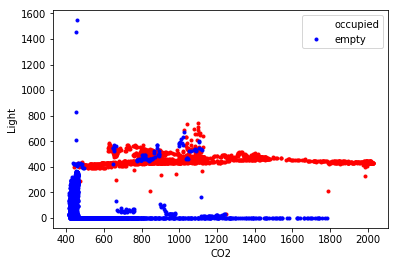

In [26]:
ax = df[df.Occupancy==1].plot(x='CO2', y='Light', ls='', marker='o', ms=3, color='r', label='occupied')
df[df.Occupancy==0].plot(x='CO2', y='Light', ls='', marker='o', ms=3, color='b', ax=ax, label='empty')
ax.set_ylabel('Light')